<a href="https://colab.research.google.com/github/CHADHURBALA/resnet/blob/main/CIFAR10_resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import math
import numpy as np
import scipy
import h5py
from tensorflow.keras import datasets
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization  
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt





In [6]:
def identity_block(X, filter, stage, block):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
  

    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filter, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path 
    X = Conv2D(filter, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


In [7]:
def convolutional_block(X, filter, stage, block):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    
    
    
    X_shortcut = X


    #Main Path
    # First component of main path 
    X = Conv2D(filter, (3, 3), strides = (2,2), name = conv_name_base + '2a', padding = 'same')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filter, (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # SHORTCUT PATH 
    X_shortcut = Conv2D(filter, kernel_size = (1, 1), strides = (2,2), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


In [11]:
def ResNet50(input_shape=(32, 32, 3), classes=10):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = identity_block(X, 64, stage=2, block='a')
    X = identity_block(X, 64, stage=2, block='b')
    X = identity_block(X, 64, stage=2, block='c')

  

    # Stage 3 
    X = convolutional_block(X, 128, stage = 3, block='a')
    X = identity_block(X, 128, stage=3, block='b')
    X = identity_block(X, 128, stage=3, block='c')
    X = identity_block(X, 128, stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, 256, stage = 4, block='a')
    X = identity_block(X, 256, stage=4, block='b')
    X = identity_block(X, 256, stage=4, block='c')
    X = identity_block(X, 256, stage=4, block='d')
    X = identity_block(X, 256, stage=4, block='e')
    X = identity_block(X, 256, stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, 512, stage = 5, block='a')
    X = identity_block(X, 512, stage=5, block='b')
    X = identity_block(X, 512, stage=5, block='c')

  
    X = GlobalAveragePooling2D()(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


In [12]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_4[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']           

In [15]:
# Function to create onehot encoding for different class categories
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [16]:
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = datasets.cifar10.load_data()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 10).T
Y_test = convert_to_one_hot(Y_test_orig, 10).T




class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

170498071/170498071 [==============================] - 4s 0us/step
number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [20]:
history = model.fit(X_train, Y_train, epochs = 25, batch_size = 32, validation_split = 0.2, shuffle=True)

Epoch 1/25
1250/1250 [==============================] - 46s 37ms/step - loss: 0.0533 - accuracy: 0.9818 - val_loss: 1.6335 - val_accuracy: 0.7055
Epoch 2/25
1250/1250 [==============================] - 45s 36ms/step - loss: 0.0548 - accuracy: 0.9821 - val_loss: 1.5628 - val_accuracy: 0.7279
Epoch 3/25
1250/1250 [==============================] - 43s 35ms/step - loss: 0.0492 - accuracy: 0.9841 - val_loss: 1.3258 - val_accuracy: 0.7522
Epoch 4/25
1250/1250 [==============================] - 43s 34ms/step - loss: 0.0446 - accuracy: 0.9858 - val_loss: 1.6902 - val_accuracy: 0.7189
Epoch 5/25
1250/1250 [==============================] - 43s 35ms/step - loss: 0.0418 - accuracy: 0.9862 - val_loss: 1.5719 - val_accuracy: 0.7238
Epoch 6/25
1250/1250 [==============================] - 46s 37ms/step - loss: 0.0556 - accuracy: 0.9837 - val_loss: 1.4817 - val_accuracy: 0.7429
Epoch 7/25
1250/1250 [==============================] - 45s 36ms/step - loss: 0.0613 - accuracy: 0.9803 - val_loss: 1.1855 -

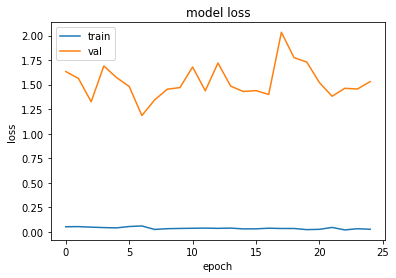

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [22]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


313/313 [==============================] - 3s 11ms/step - loss: 1.6429 - accuracy: 0.7603
Loss = 1.6429208517074585
Test Accuracy = 0.7602999806404114


Pick a number: 3456
1/1 [==============================] - 0s 25ms/step
[2.0678979e-08 2.6127609e-09 1.2485738e-06 9.9954706e-01 5.0975097e-05
 2.5808113e-04 1.3865007e-04 2.5847802e-07 2.7460360e-06 9.3439593e-07]
3


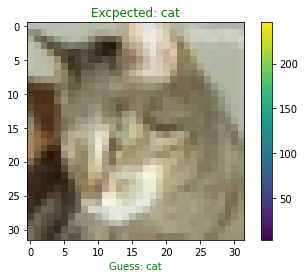

In [24]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, im, correct_label):
  class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
  prediction = list(model.predict(np.array([im])))
  
  prediction = prediction[0]
  print(prediction)

  r = np.argmax(prediction)
  print(r)
    
  predicted_class = class_names[r]

  show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
  plt.figure()
  plt.imshow(img)
  plt.title("Excpected: " + f"{label}", color='green')
  plt.xlabel("Guess: " + f"{guess}", color='green')
  plt.colorbar()
  plt.grid(False)
  plt.show()


def get_number():
  while True:
    num = input("Pick a number: ")
    if num.isdigit():
      num = int(num)
      if 0 <= num <= 10000:
        return int(num)
    else:
      print("Try again...")

num = get_number()
image = X_test_orig[num]
im = X_test[num]
label = list(Y_test[num])

l= 1000
for index, val in enumerate(label):
  if val == 1:
    l = index
    break


predict(model, image, im, l)